# `vaex` @ PyData Budapest 2020

## Machine Learning Example - Predict the duration of taxi trips

To find out more details check out
[ML impossible: Train 1 billion samples in 5 minutes on your laptop using Vaex and Scikit-Learn](https://towardsdatascience.com/ml-impossible-train-a-1-billion-sample-model-in-20-minutes-with-vaex-and-scikit-learn-on-your-9e2968e6f385).

Running this notebooks requires `vaex==3.0.0`

In [1]:
import vaex
vaex.multithreading.thread_count_default = 8

import pylab as plt
import numpy as np

import warnings; warnings.simplefilter('ignore')

### Initial step: reading the data and do a train/test split immediately

In [2]:
!du -h /data/taxi/*

13G	/data/taxi/nyc_taxi_2012_zones_jovan_verify.hdf5
52G	/data/taxi/yellow_taxi_2009_2015_zones.hdf5
15G	/data/taxi/yellow_taxi_2012.hdf5
12G	/data/taxi/yellow_taxi_2012_zones.hdf5
13G	/data/taxi/yellow_taxi_2012_zones_mask.hdf5
12G	/data/taxi/yellow_taxi_2012_zones_nomask.hdf5


In [3]:
df = vaex.open('/data/taxi/yellow_taxi_2012.hdf5')

# Train / test split (by date)
df_train, df_test = df.ml.train_test_split(test_size=0.15)

print(f'Number of samples in the full dataset: {len(df):,}')
print(f'Number of samples in the training set: {len(df_train):,}')
print(f'Number of samples in the test set:       {len(df_test):,}')

# Check if the lengths of the datasets match
assert len(df) == len(df_test) + len(df_train)

Number of samples in the full dataset: 178,544,324
Number of samples in the training set: 151,762,675
Number of samples in the test set:       26,781,649


### Define the label

In [4]:
# Time in transit (minutes) - This is the target variable
df_train['trip_duration_min'] = (df_train.dropoff_datetime - df_train.pickup_datetime) / \
                                   np.timedelta64(1, 'm')

### Feature engineering

In [5]:
# Speed (miles per hour) - Used for cleaning of the training data
df_train['trip_speed_mph'] = df_train.trip_distance / \
                                ((df_train.dropoff_datetime - df_train.pickup_datetime) / \
                                np.timedelta64(1, 'h'))

In [6]:
# Pickup datetime features
df_train['pickup_time'] = df_train.pickup_datetime.dt.hour + df_train.pickup_datetime.dt.minute / 60.
df_train['pickup_day'] = df_train.pickup_datetime.dt.dayofweek
df_train['pickup_is_weekend'] = (df_train.pickup_day>=5).astype('int')

In [7]:
# Arc distance  in miles
def arc_distance(theta_1, phi_1, theta_2, phi_2):
    temp = (np.sin((theta_2-theta_1)/2*np.pi/180)**2
           + np.cos(theta_1*np.pi/180)*np.cos(theta_2*np.pi/180) * np.sin((phi_2-phi_1)/2*np.pi/180)**2)
    distance = 2 * np.arctan2(np.sqrt(temp), np.sqrt(1-temp))
    return distance * 3958.8

# Create the feature
df_train['arc_distance'] = arc_distance(df_train.pickup_longitude, 
                                        df_train.pickup_latitude, 
                                        df_train.dropoff_longitude, 
                                        df_train.dropoff_latitude).jit_numba()

In [8]:
def direction_angle(theta_1, phi_1, theta_2, phi_2):
    dtheta = theta_2 - theta_1
    dphi = phi_2 - phi_1
    radians = np.arctan2(dtheta, dphi)
    return np.rad2deg(radians)

# Create the feature
df_train['direction_angle'] = direction_angle(df_train.pickup_longitude, 
                                              df_train.pickup_latitude, 
                                              df_train.dropoff_longitude, 
                                              df_train.dropoff_latitude).jit_numba()

### Data cleaning

In [9]:
# Filter abnormal number of passengers
df_train = df_train[(df_train.passenger_count>0) & (df_train.passenger_count<7)]

# Select taxi trips have travelled maximum 7 miles (but also with non-zero distance).
df_train = df_train[(df_train.trip_distance > 0) & (df_train.trip_distance < 7)]

# Filter taxi trips that have durations longer than 25 minutes or that lasted less than 3 minutes
df_train = df_train[(df_train.trip_duration_min > 3) & (df_train.trip_duration_min < 25)]

# Filter out errouneous average trip speeds.
df_train = df_train[(df_train.trip_speed_mph > 1) & (df_train.trip_speed_mph < 60)]

# Define the NYC boundaries
long_min = -74.05
long_max = -73.75
lat_min = 40.58
lat_max = 40.90

# Make a selection based on the boundaries
df_train = df_train[(df_train.pickup_longitude > long_min)  & (df_train.pickup_longitude < long_max) & \
                    (df_train.pickup_latitude > lat_min)    & (df_train.pickup_latitude < lat_max) & \
                    (df_train.dropoff_longitude > long_min) & (df_train.dropoff_longitude < long_max) & \
                    (df_train.dropoff_latitude > lat_min)   & (df_train.dropoff_latitude < lat_max)]

# If there are unknown (N/A) pick-up or drop-off locations, choose a representative value. 
df_train['dropoff_latitude'] = df_train.dropoff_latitude.fillna(value=40.76)
df_train['pickup_latitude'] = df_train.pickup_latitude.fillna(value=40.76)

df_train['dropoff_longitude'] = df_train.dropoff_longitude.fillna(value=-73.99)
df_train['pickup_longitude'] = df_train.pickup_longitude.fillna(value=-73.99)

## `vaex-ml`

A `vaex` package for machine learning. 

Implements various data transformers:
 - numerical scalers
 - categorical encoders
 - PCA transformer
 - GroupBy transformers
 - more coming soon
 
Wrappers around other popular model libraries
 - xgboost / lightgbm / catboost
 - scikit-learn
 - tensorflow / keras (coming soon!)
 
[We are working on better integration between scikit-learn and vaex](https://github.com/scikit-learn/scikit-learn/pull/14963).

scikit-learn PR #14963

In [10]:
import vaex.ml

### Transform features: PCA of the pick-up and drop-off locations

In [11]:
# PCA of the pickup and dropoff locations - helps to "straighten out" the coordinates

# pickup transformations
pca_pu = vaex.ml.PCA(features=['pickup_longitude', 'pickup_latitude'], n_components=2, progress=True)
df_train = pca_pu.fit_transform(df_train)

# dropoff transformations
pca_do = vaex.ml.PCA(features=['dropoff_longitude', 'dropoff_latitude'], n_components=2, progress=True)
df_train = pca_do.fit_transform(df_train)

[###################################-----] 100.00% elapsed time  :     1.05s =  0.0m =  0.0h
[####################################----] 100.00% elapsed time  :     0.38s =  0.0m =  0.0h
[####################################----] 100.00% elapsed time  :     0.23s =  0.0m =  0.0h
[#####################################---] 100.00% elapsed time  :     0.37s =  0.0m =  0.0h
 

Preview the new columns (PCA transformations)

In [12]:
df_train

#,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,payment_type,trip_distance,pickup_longitude,pickup_latitude,rate_code,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount,trip_duration_min,trip_speed_mph,pickup_time,pickup_day,pickup_is_weekend,arc_distance,direction_angle,PCA_0,PCA_1,PCA_2,PCA_3
0,VTS,2012-02-11 23:30:00.000000000,2012-02-11 23:39:00.000000000,1,CSH,1.2599999904632568,-73.97868347167969,40.7244987487793,1.0,nan,-73.99909973144531,40.729671478271484,6.5,0.5,0.5,0.0,0.0,7.5,9.0,8.399999936421713,23.5,5,1,1.4140833616256714,-75.78253936767578,-0.020595001056790352,-0.017823772504925728,-0.029927730560302734,0.004115740768611431
1,VTS,2012-02-11 23:25:00.000000000,2012-02-11 23:40:00.000000000,3,CRD,3.2300000190734863,-73.94949340820312,40.71410369873047,1.0,nan,-74.00199127197266,40.71927261352539,10.899999618530273,0.5,0.5,2.8499999046325684,0.0,14.75,15.0,12.920000076293945,23.416666666666668,5,1,3.628631830215454,-84.3768081665039,-0.01142774149775505,-0.0474223867058754,-0.04016195982694626,0.0006867535412311554
2,VTS,2012-02-11 22:44:00.000000000,2012-02-11 22:50:00.000000000,2,CSH,1.840000033378601,-73.93893432617188,40.75250244140625,1.0,nan,-73.96456146240234,40.760337829589844,6.900000095367432,0.5,0.5,0.0,0.0,7.900000095367432,6.0,18.40000033378601,22.733333333333334,5,1,1.776997447013855,-72.99921417236328,0.02564183808863163,-0.03286890685558319,0.014821933582425117,-0.007320371922105551
3,VTS,2012-02-11 23:20:00.000000000,2012-02-11 23:39:00.000000000,1,CRD,5.510000228881836,-73.9596176147461,40.80888366699219,1.0,nan,-73.98733520507812,40.74416732788086,15.699999809265137,0.5,0.5,3.240000009536743,0.0,19.940000534057617,19.0,17.400000722784746,23.333333333333332,5,1,2.278529644012451,-156.8148651123047,0.058389149606227875,0.01747247390449047,-0.011329693719744682,0.0024888506159186363
4,VTS,2012-02-11 22:41:00.000000000,2012-02-11 22:46:00.000000000,1,CSH,0.7900000214576721,-74.00645446777344,40.70814514160156,1.0,nan,-73.99230194091797,40.74345779418945,4.900000095367432,0.5,0.5,0.0,0.0,5.900000095367432,5.0,9.480000257492065,22.683333333333334,5,1,1.186814308166504,21.83981704711914,-0.05032758042216301,-0.005388250574469566,-0.014699360355734825,0.006206006743013859
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"119,415,361",CMT,2012-12-24 10:37:56.000000000,2012-12-24 10:47:08.000000000,1,CSH,3.799999952316284,-73.87118530273438,40.77067947387695,1.0,0.0,-73.9106216430664,40.745765686035156,12.5,0.0,0.5,0.0,0.0,13.0,9.2,24.78260838467142,10.616666666666667,0,0,2.7663631439208984,-122.28251647949219,0.08078788220882416,-0.07621920108795166,0.032961733639240265,-0.06016731262207031
"119,415,362",CMT,2012-12-24 10:46:58.000000000,2012-12-24 10:56:29.000000000,1,CSH,1.7999999523162842,-73.96009063720703,40.77359390258789,1.0,0.0,-73.97677612304688,40.750755310058594,9.0,0.0,0.5,0.0,0.0,9.5,9.516666666666667,11.348511082904768,10.766666666666667,0,0,1.2324864864349365,-143.84877014160156,0.029851939529180527,-0.003293338231742382,4.210078623145819e-05,-0.0025686207227408886
"119,415,363",CMT,2012-12-24 07:10:44.000000000,2012-12-24 07:16:48.000000000,1,CSH,2.0999999046325684,-73.99629211425781,40.73793411254883,1.0,0.0,-73.97488403320312,40.75730514526367,8.0,0.0,0.5,0.0,0.0,8.5,6.066666666666666,20.76922982603639,7.166666666666667,0,0,1.5245623588562012,47.85973358154297,-0.0203888900578022,0.004324158653616905,0.006527906283736229,-0.0004675083328038454
"119,415,364",CMT,2012-12-24 21:09:56.000000000,2012-12-24 21:13:22.000000000,1,CSH,0.30000001192092896,-73.96232604980469,40.77641296386719,1.0,0.0,-73.95834350585938,40.774906158447266,4.0,0.5,0.5,0.0,0.0,5.0,3.433333333333333,5.242718654928855,21.15,0,0,0.27666980028152466,110.72425842285156,0.030769556760787964,0.00018547754734754562,0.030373375862836838,-0.004311750642955303


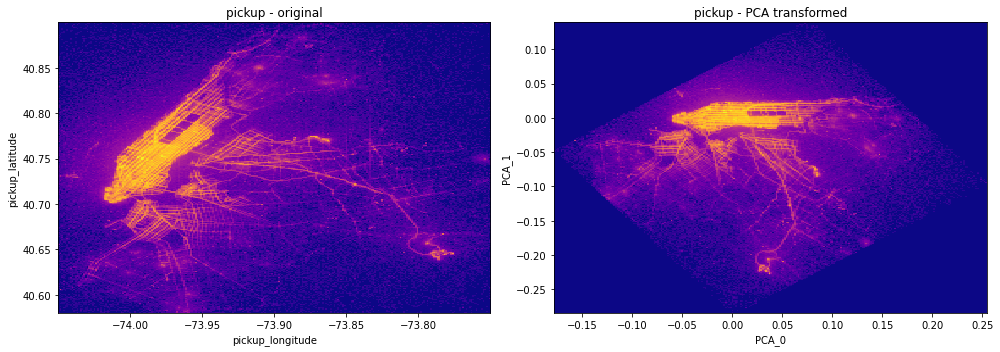

In [13]:
plt.figure(figsize=(14, 5))

plt.subplot(121)
plt.title('pickup - original')
df_train.plot(df_train.pickup_longitude, df_train.pickup_latitude,
           colormap='plasma', f='log1p', shape=256, colorbar=False)

plt.subplot(122)
plt.title('pickup - PCA transformed')
df_train.plot(df_train.PCA_0, df_train.PCA_1,
           colormap='plasma', f='log1p', shape=256, colorbar=False)

plt.tight_layout()
plt.show()

### Handling temporal (cyclical) features

- Assume the temporal feature is the θ coordinate of a unit circle in polar coordinates. Conver it to Cartesian (x,y) coordinates. This preserves the continuity (12 o'clock is close to 1 o'clock).

In [14]:
# Time
cycl_transform_time = vaex.ml.CycleTransformer(features=['pickup_time'], n=24)
df_train = cycl_transform_time.fit_transform(df_train)

# Day
cycl_transform_day = vaex.ml.CycleTransformer(features=['pickup_day'], n=7)
df_train = cycl_transform_day.fit_transform(df_train)

# Direction angle
cycl_transform_angle = vaex.ml.CycleTransformer(features=['direction_angle'], n=360)
df_train = cycl_transform_angle.fit_transform(df_train)

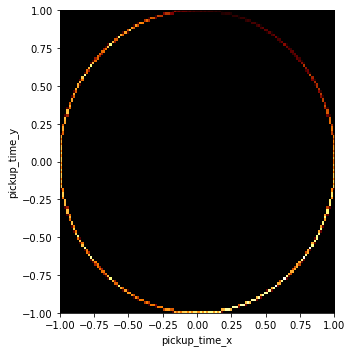

In [15]:
# Let's see how the transformed date would look like
df_train.plot(x='pickup_time_x', y='pickup_time_y',
              shape=128, limits=[-1, 1],
              figsize=(5, 5),
              colorbar=False)
plt.show()

### Scaling of numerical features

In [16]:
# Standard scaling of numerical features
standard_scaler = vaex.ml.StandardScaler(features=['arc_distance'])
df_train = standard_scaler.fit_transform(df_train)

### Preview the training features

In [17]:
# Select all the features to be used for training the model
features = df_train.get_column_names(regex='PCA*') + \
           df_train.get_column_names(regex='standard_scaled_*') + \
           df_train.get_column_names(regex='.*_x') + \
           df_train.get_column_names(regex='.*_y') + \
           ['pickup_is_weekend']

# Preview the features
df_train.head(10)[features]

#,PCA_0,PCA_1,PCA_2,PCA_3,standard_scaled_arc_distance,pickup_time_x,pickup_day_x,direction_angle_x,pickup_time_y,pickup_day_y,direction_angle_y,pickup_is_weekend
0,-0.020595,-0.0178238,-0.0299277,0.00411574,0.274201,0.991445,-0.222521,0.245603,-0.130526,-0.974928,-0.969371,1
1,-0.0114277,-0.0474224,-0.040162,0.000686754,2.73354,0.988362,-0.222521,0.0979857,-0.152123,-0.974928,-0.995188,1
2,0.0256418,-0.0328689,0.0148219,-0.00732037,0.67723,0.945519,-0.222521,0.292385,-0.325568,-0.974928,-0.956301,1
3,0.0583891,0.0174725,-0.0113297,0.00248885,1.2342,0.984808,-0.222521,-0.919238,-0.173648,-0.974928,-0.393703,1
4,-0.0503276,-0.00538825,-0.0146994,0.00620601,0.0218105,0.941176,-0.222521,0.928228,-0.337917,-0.974928,0.372013,1
5,-0.0275531,0.00711023,-0.0278285,0.0161444,-0.896509,0.994056,-0.222521,0.644808,-0.108867,-0.974928,-0.764345,1
6,-0.0723734,-0.028767,-0.0750212,-0.0241434,-1.29619,0.94693,-0.222521,1,-0.321439,-0.974928,0,1
7,0.0626352,-0.00947211,0.0404331,-0.00821181,-0.17695,0.94693,-0.222521,-0.733494,-0.321439,-0.974928,-0.679696,1
8,-0.0259672,-0.0159551,-0.0287257,-0.00371009,-0.632151,0.938191,-0.222521,0.502527,-0.346117,-0.974928,-0.864562,1
9,0.00118875,0.00155669,0.00217677,-0.00900871,-0.453891,0.942641,-0.222521,-0.391236,-0.333807,-0.974928,0.92029,1


### Set the target variable

In [18]:
target = 'trip_duration_min'

### Train a machine learning model

In [19]:
from sklearn.linear_model import SGDRegressor
from vaex.ml.sklearn import IncrementalPredictor

# Define the base model
model = SGDRegressor(learning_rate='constant', eta0=0.0001)

# The Vaex incremental model wrapper
vaex_model = IncrementalPredictor(features=features,
                                  target=target,
                                  model=model,
                                  batch_size=11_000_000, 
                                  num_epochs=1, 
                                  shuffle=False, 
                                  prediction_name='predicted_duration_min')

# Fit the model
vaex_model.fit(df=df_train, progress='widget')

### Let's see the predictions!

In [20]:
# Standard in-memory predict
vaex_model.predict(df_train)

array([10.83679091, 17.55674479, 10.9744867 , ..., 10.45261422,
        6.56544312,  9.10941091])

Vaex makes models transformers!

In [21]:
df_train = vaex_model.transform(df_train)
# See a portion of the predictions
df_train.head(5)['trip_duration_min', 'predicted_duration_min']

#,trip_duration_min,predicted_duration_min
0,9,10.8368
1,15,17.5567
2,6,10.9745
3,19,13.2393
4,5,10.2093


The prediction is an expression! Opprotunities for post-processing, ensembles etc..

Values lower than 3 minutes are set to 3; values higher than 25 minutes are set to 25

In [22]:
df_train['pred_final'] = df_train.predicted_duration_min.clip(3, 25)

## But.. what about the test set?!

### State transfer (a.k.a the `vaex` automatic pipeline)

The operations done on the data are recorded in the `state` of the DataFrame.

In [23]:
df_train.state_get()

{'virtual_columns': {'pickup_longitude': 'fillna(__pickup_longitude, value=-73.99)',
  'pickup_latitude': 'fillna(__pickup_latitude, value=40.76)',
  'dropoff_longitude': 'fillna(__dropoff_longitude, value=-73.99)',
  'dropoff_latitude': 'fillna(__dropoff_latitude, value=40.76)',
  'trip_duration_min': '((dropoff_datetime - pickup_datetime) / var_time_delta)',
  'trip_speed_mph': '(trip_distance / ((dropoff_datetime - pickup_datetime) / var_time_delta_1))',
  'pickup_time': '(dt_hour(pickup_datetime) + (dt_minute(pickup_datetime) / 60.0))',
  'pickup_day': 'dt_dayofweek(pickup_datetime)',
  'pickup_is_weekend': "astype((pickup_day >= 5), 'int')",
  'arc_distance': '_jit(__pickup_latitude, __pickup_longitude, __dropoff_latitude, __dropoff_longitude)',
  'direction_angle': '_jit_1(__dropoff_longitude, __pickup_longitude, __dropoff_latitude, __pickup_latitude)',
  'PCA_0': '(pickup_longitude - -73.9806109361281) * 0.5991687373455696 + (pickup_latitude - 40.75166597207298) * 0.800622772713

Write the state to disk (serializes the operations and model).

In [24]:
df_train.state_write('./taxi_ml_state.json')